In [44]:
library(tidyverse)
library(Seurat)
library(ggplot2)
library(reshape2)
library(dplyr)
library(princurve)
library(grid)
library(ggraph)
library(igraph)
library(ComplexHeatmap)
library(plyr)
library(circlize)
library(cowplot)
library(qusage)
library(msigdbr)
library(clusterProfiler)
library(ggrepel)
library(viridis)
library(extrafont)
library(gplots)
library(pheatmap)
library(parallel)
options(bitmapType='cairo')
library(org.Hs.eg.db)
library(clusterProfiler)
library(VennDiagram)
library(UpSetR)

source("/storage/coda1/p-ggibson3/0/mduan31/rich_project_bio-gibson/public_code/dotplot_mmnorm.R")
source("/storage/coda1/p-ggibson3/0/mduan31/rich_project_bio-gibson/public_code/seurat_visualization.R")

Registering fonts with R

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:igraph’:

    normalize, path, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Bio

In [26]:
pc = readRDS("BMPC_SeuratObj.rds")
dim(pc)
names(pc)

[1] 18727 17347

[1] "RNA"        "SCT"        "integrated" "umap"

### Code for Main Figure 1 

- Figure 1B: cell quality control <br>
All the samples used the same cutoffs to do the sample-level cell quality control, here we used CLS055 as a showcase.

In [3]:
## Load data
cls055 = Read10X_h5("./CLS055_All/filtered_feature_bc_matrix.h5", use.names = TRUE, unique.features = TRUE)

The sequencing data from the second sequencing run, including samples from donor CLS055 and CLS058, experienced sample index hopping issue. Fortunately, 10x genomics technique support team helped us cleaned the cell barcodes so that we can use the cleaned data to continue the downstream analysis.

In [4]:
## Load clean barcode files 
temp = list.files(path = "./clean_barcode/",pattern="CLS055",full.names = TRUE)
myfiles = lapply(temp, function(x) read.delim(x,header = F,stringsAsFactors = F))
filename = strsplit(temp,"clean_barcode/")
filename = sapply(strsplit(sapply(filename,"[",2),".txt"),"[",1)
filename = sapply(strsplit(filename,"cleanbarcodes"),"[",2)
names(myfiles) = c("CLS055_popA","CLS055_popB","CLS055_popD")
                 
clean.barcode = vector("list")
for(name in names(myfiles)){
  if(grepl("^CLS055|^CLS058",name)){
    if(grepl("popA$",name)){
      cln = paste0(as.matrix(myfiles[[name]]),"-",1)
    }else if(grepl("popB$",name)){
      cln = paste0(as.matrix(myfiles[[name]]),"-",2)
    }else{
      cln = paste0(as.matrix(myfiles[[name]]),"-",3)
    }
  }else{
    cln = paste0(as.matrix(myfiles[[name]]),"-",1)
  }
  clean.barcode[[name]] = cln
}



In [5]:
## Create Seurat object using cleaned data
pc.clean.data = cls055[,c(clean.barcode[["CLS055_popA"]],clean.barcode[["CLS055_popB"]],clean.barcode[["CLS055_popD"]])] 
cls055 <- CreateSeuratObject(counts = pc.clean.data, project = "CLS055",min.cells = 14) # 


In [6]:
## adding summarized mitochodrial, ribosomal and immunoglobulin gene percentage to the cell metadata
temp = sapply(strsplit(as.character(colnames(cls055)),"-"),'[',2)
temp[which(temp=="1")] = "popA"
temp[which(temp=="2")] = "popB"
temp[which(temp=="3")] = "popD"
names(temp) = colnames(cls055)
cls055[["Subject"]] <- temp
Idents(cls055) <- "Subject"

cls055[["percent.mito"]] <- PercentageFeatureSet(object = cls055, pattern = "^MT-")
cls055[["percent.ribo"]] <- PercentageFeatureSet(object = cls055, pattern = "^RPS|^RPL")
cls055[["percent.Ig"]] <- PercentageFeatureSet(object = cls055, pattern = "^IGH|^IGL|^IGK")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


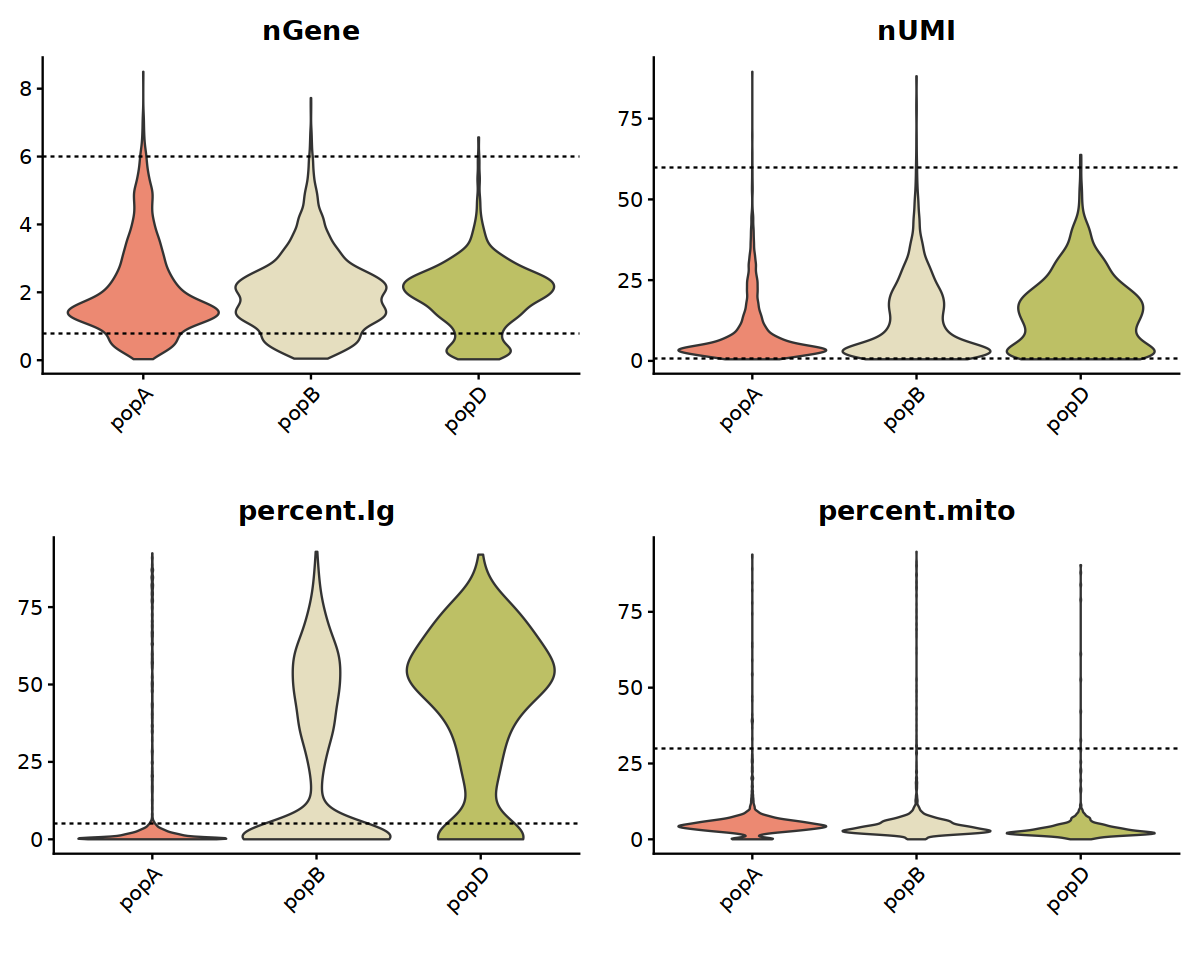

In [10]:
options(repr.plot.width=10, repr.plot.height=8)
p1 <- VlnPlot(object = cls055, features = "nFeature_RNA",group.by = "Subject", ncol = 1,pt.size = 0,cols = c("#EC8972","#E5DEBF","#BDC065")) +
  scale_y_continuous(labels = function(y) y / 1000) + 
geom_hline(yintercept = 800,linetype = "dashed") + geom_hline(yintercept = 6000,linetype = "dashed") + 
ggtitle("nGene")+theme(legend.position = "none")+xlab("")
                     
p2 <- VlnPlot(object = cls055, features = "nCount_RNA",group.by = "Subject", ncol = 1,pt.size = 0,
              cols = c("#EC8972","#E5DEBF","#BDC065"))+ scale_y_continuous(labels = function(y) y / 1000) + 
      geom_hline(yintercept = 600,linetype = "dashed") + geom_hline(yintercept = 60000,linetype = "dashed")  + 
      ggtitle("nUMI")+theme(legend.position = "none")+xlab("")
                                                                           
p3 <- VlnPlot(object = cls055, features = "percent.Ig",group.by = "Subject", ncol = 1,pt.size = 0,
              cols = c("#EC8972","#E5DEBF","#BDC065"))+ geom_hline(yintercept = 5,linetype = "dashed")  + 
              ggtitle("percent.Ig")+theme(legend.position = "none")+xlab("")
                                                                           
p4 <- VlnPlot(object = cls055, features = "percent.mito",group.by = "Subject", ncol = 1,pt.size = 0,
              cols = c("#EC8972","#E5DEBF","#BDC065"))+ geom_hline(yintercept = 30,linetype = "dashed")  + 
             ggtitle("percent.mito")+theme(legend.position = "none")+xlab("")
plot_grid(p1,p2,p3,p4,ncol = 2)

- Figure 1C: UMAP colored by the current cell cluster id <br>

In [27]:
pc@meta.data = pc@meta.data  %>%
select(nCount_RNA, nFeature_RNA, Subject.x, Cell_type.x,Sample, percent.mito, percent.ribo, percent.Ig,IgGroup, FeatureGroup,
         cluster_id_old,cluster_id,stage,Donor,isotype) %>%
  dplyr::rename(Subject = Subject.x,
         Cell_type = Cell_type.x)


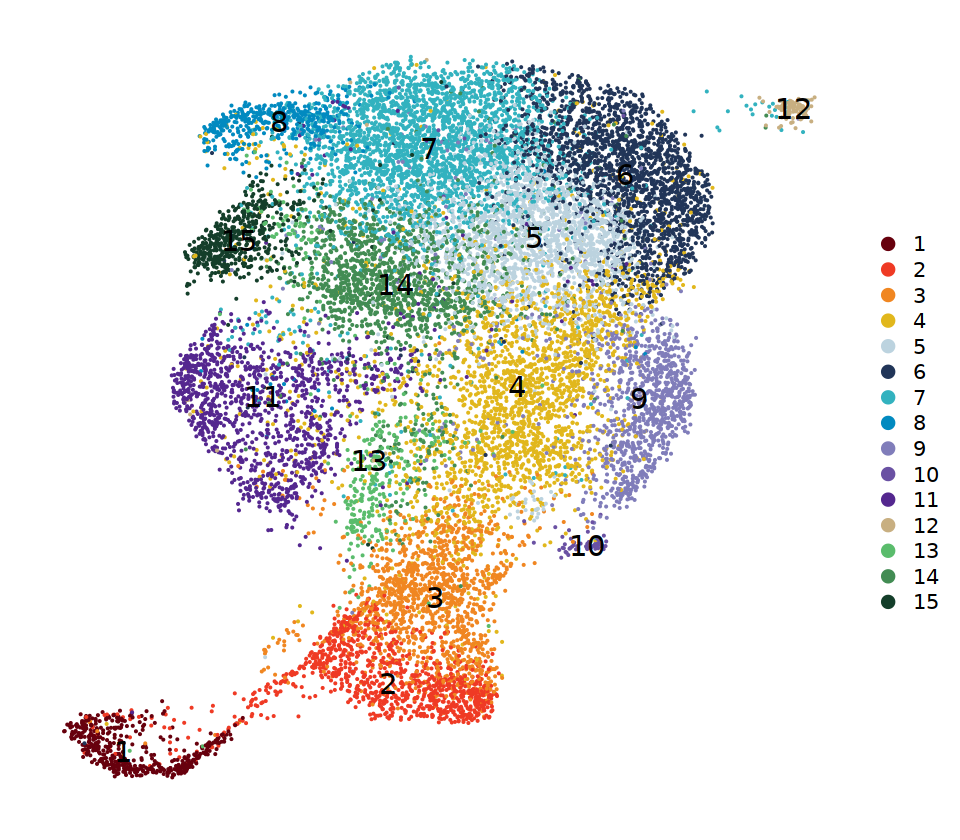

In [22]:
options(repr.plot.width=8, repr.plot.height=7)
seurat.dimplot(pc,group.by = "cluster_id",cols = c("#67000D", "#EF3A24", "#F08621",  "#E1B71C","#BCD3DF",
          "#213558", "#32B2BF","#018AC0","#807DBA","#6A51A3",
          "#54278F","#C8AF81","#5ABC6C","#428C53","#143E2A"),label.size = 6)+theme(legend.position = "right")

- Figure 1D and 1G: The proportion of FACS-sorting labeled cell type (including PopA, B and D) and scVDJ-seq identified cell isotype (including IgA1, IgA2, IgG1 - IgG4, IgM, IgD adn IgE) in each scRNA-seq defined cell cluster.

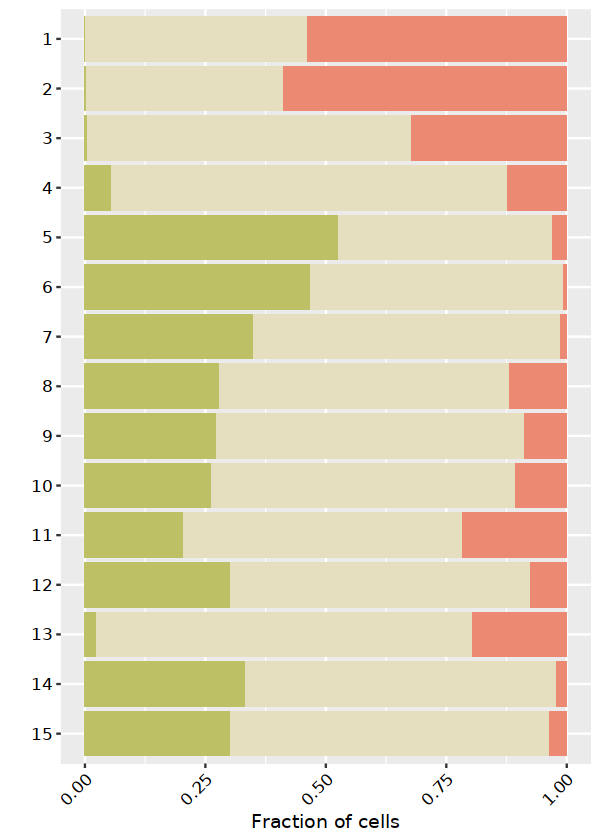

In [24]:
## Figure 1D
options(repr.plot.width=5, repr.plot.height=7)
tt = as.data.frame(round(prop.table(x = table(pc$Cell_type,pc$cluster_id),margin = 2),5))
names(tt) = c("Cell_type","cluster_id","Freq")
tt$cluster_id = factor(tt$cluster_id,levels = c(15:1))

ggplot(tt,aes(y = Freq, x = factor(cluster_id), fill = Cell_type)) + geom_bar(stat="identity")+ coord_flip() + 
  scale_fill_manual(values=c("#EC8972","#E5DEBF","#BDC065")) + labs(x=" ", y="Fraction of cells") + theme(axis.text.x=element_text(angle = 45,vjust = 1,hjust = 1,colour="black", size = rel(1.1)), axis.text.y=element_text(colour="black", size = rel(1.1)),legend.position = "none") #+ guides(fill=guide_legend(ncol=2))


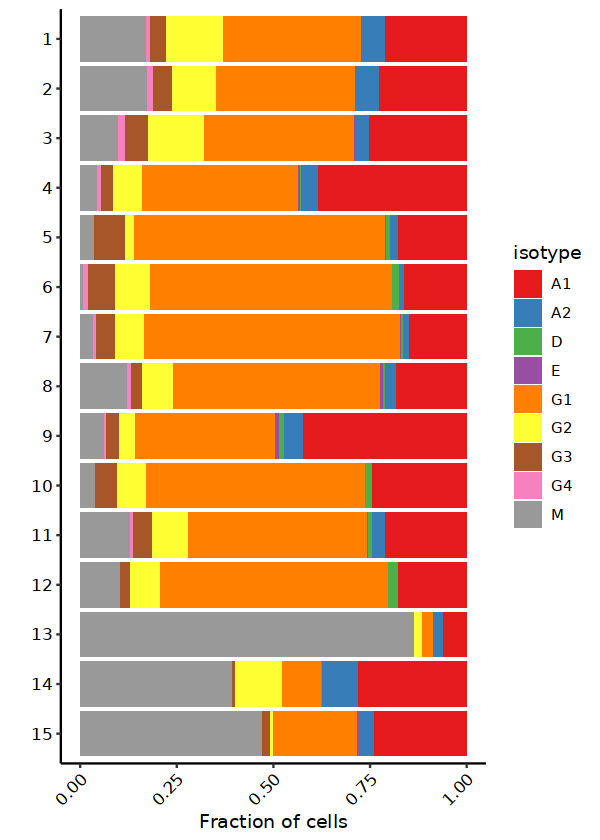

In [29]:
## Figure 1G
tt = as.data.frame(round(prop.table(x = table(pc$isotype,pc$cluster_id),margin = 2),5))
names(tt) = c("isotype","cluster_id","Freq")
tt$cluster_id = factor(tt$cluster_id,levels = c(15:1))
ggplot(tt,aes(y = Freq, x = factor(cluster_id), fill = isotype)) + geom_bar(stat="identity")+ coord_flip() + 
  scale_fill_brewer(palette="Set1") + theme_classic()+
  labs(x=" ", y="Fraction of cells") + 
theme(axis.text.x=element_text(angle = 45,vjust = 1,hjust = 1,colour="black", size = rel(1.1)), 
      axis.text.y=element_text(colour="black", size = rel(1.1)),legend.position = "right") #+ guides(fill=guide_legend(ncol=2))


- Figure 1E: Plasma cell representative gene expression visualization

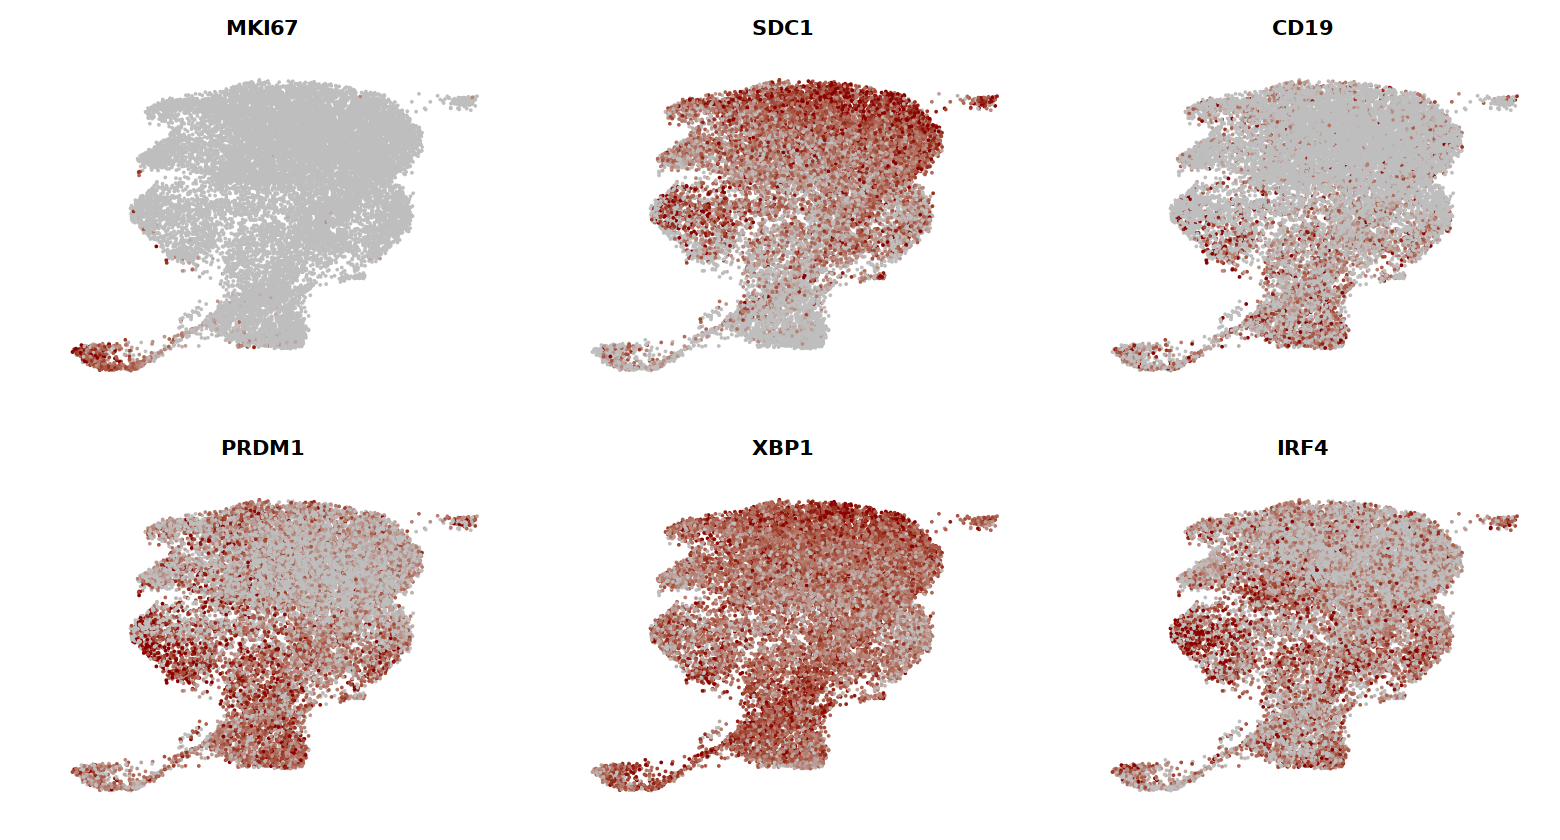

In [32]:
options(repr.plot.width=13, repr.plot.height=7)
p1 <- FeaturePlot(object = pc, pt.size = 0.01,features = 'MKI67',min.cutoff = "q05", max.cutoff = "q95",ncol = 1, col = c("grey","darkred")) + 
theme(axis.line=element_blank(),axis.text.x=element_blank(),axis.text.y=element_blank(),axis.ticks=element_blank(),axis.title.x=element_blank(),axis.title.y=element_blank(),panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),panel.grid.minor=element_blank(),plot.background=element_blank(),legend.position = "none",plot.title = element_text(size=12,face = "bold")) 
p2 <- FeaturePlot(object = pc,pt.size = 0.01, features = 'SDC1',min.cutoff = "q05", max.cutoff = "q95",ncol = 1, col = c("grey","darkred")) + 
theme(axis.line=element_blank(),axis.text.x=element_blank(),axis.text.y=element_blank(),axis.ticks=element_blank(),axis.title.x=element_blank(),axis.title.y=element_blank(),panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),panel.grid.minor=element_blank(),plot.background=element_blank(),legend.position = "none",plot.title = element_text(size=12,face = "bold")) 
p3 <- FeaturePlot(object = pc,pt.size = 0.01, features = 'CD19',min.cutoff = "q05", max.cutoff = "q95",ncol = 1, col = c("grey","darkred")) + 
theme(axis.line=element_blank(),axis.text.x=element_blank(),axis.text.y=element_blank(),axis.ticks=element_blank(),axis.title.x=element_blank(),axis.title.y=element_blank(),panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),panel.grid.minor=element_blank(),plot.background=element_blank(),legend.position = "none",plot.title = element_text(size=12,face = "bold")) 
p4 <- FeaturePlot(object = pc,pt.size = 0.01, features = 'PRDM1',min.cutoff = "q05", max.cutoff = "q95",ncol = 1, col = c("grey","darkred")) + 
theme(axis.line=element_blank(),axis.text.x=element_blank(),axis.text.y=element_blank(),axis.ticks=element_blank(),axis.title.x=element_blank(),axis.title.y=element_blank(),panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),panel.grid.minor=element_blank(),plot.background=element_blank(),legend.position = "none",plot.title = element_text(size=12,face = "bold")) 
p5 <- FeaturePlot(object = pc,pt.size = 0.01, features = 'XBP1',min.cutoff = "q05", max.cutoff = "q95",ncol = 1, col = c("grey","darkred")) + 
theme(axis.line=element_blank(),axis.text.x=element_blank(),axis.text.y=element_blank(),axis.ticks=element_blank(),axis.title.x=element_blank(),axis.title.y=element_blank(),panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),panel.grid.minor=element_blank(),plot.background=element_blank(),legend.position = "none",plot.title = element_text(size=12,face = "bold")) 
p6 <- FeaturePlot(object = pc,pt.size = 0.01, features = 'IRF4',min.cutoff = "q05", max.cutoff = "q95",ncol = 1, col = c("grey","darkred")) + 
theme(axis.line=element_blank(),axis.text.x=element_blank(),axis.text.y=element_blank(),axis.ticks=element_blank(),axis.title.x=element_blank(),axis.title.y=element_blank(),panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),panel.grid.minor=element_blank(),plot.background=element_blank(),legend.position = "none",plot.title = element_text(size=12,face = "bold")) 
plot_grid(p1,p2,p3,p4,p5,p6, ncol = 3)


- Figure 1F: MHC class I and II gene expression

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


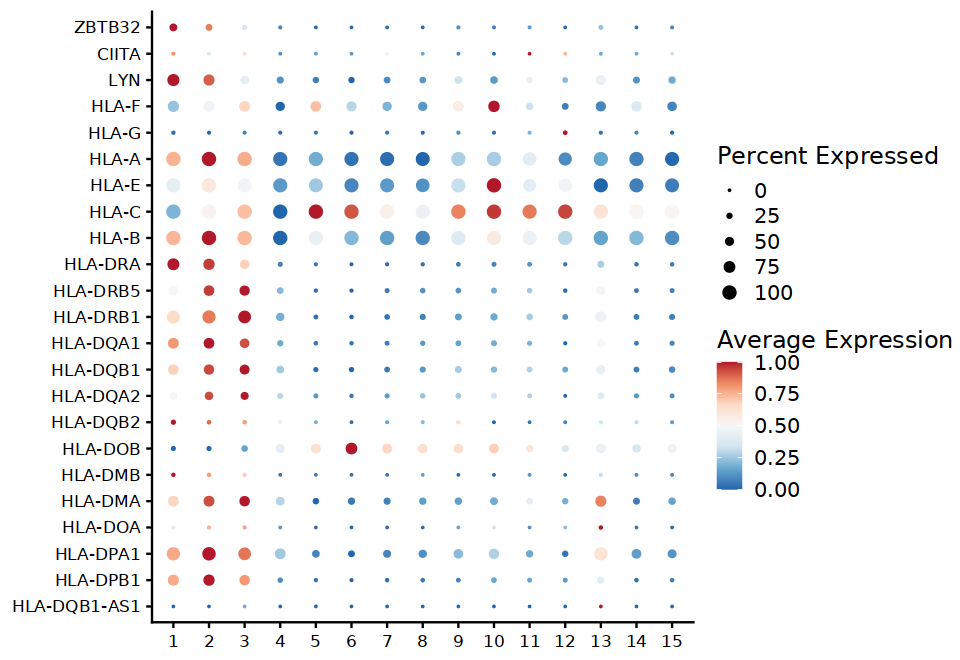

In [35]:
options(repr.plot.width=8, repr.plot.height=5.5)
temp = row.names(pc)[grepl("^HLA-",row.names(pc))]
dotplot(pc,features = c("ZBTB32","CIITA","LYN",temp),
        scale.by = "radius",col.min = 0,assay = "RNA",scale = "mm",dot.scale = 3,group.by = "cluster_id")+
  scale_color_distiller(palette = "RdBu",direction = -1)+ 
  #RotatedAxis()+
  coord_flip()+
  #coord_polar()+
  theme(axis.text.x = element_text(angle =0,vjust = 0.5,hjust = 0.5,size =10))+ 
  theme(axis.text.y = element_text(size = 10),legend.position = "right",
        axis.title.x=element_blank(),axis.title.y=element_blank())


- Figure 1H: Newly formed BMPC representative gene expression

In [36]:
cell_cluster.color = c("#67000D", "#EF3A24", "#F08621",  "#E1B71C","#BCD3DF",
          "#213558", "#32B2BF","#018AC0","#807DBA","#6A51A3",
          "#54278F","#C8AF81","#5ABC6C","#428C53","#143E2A")

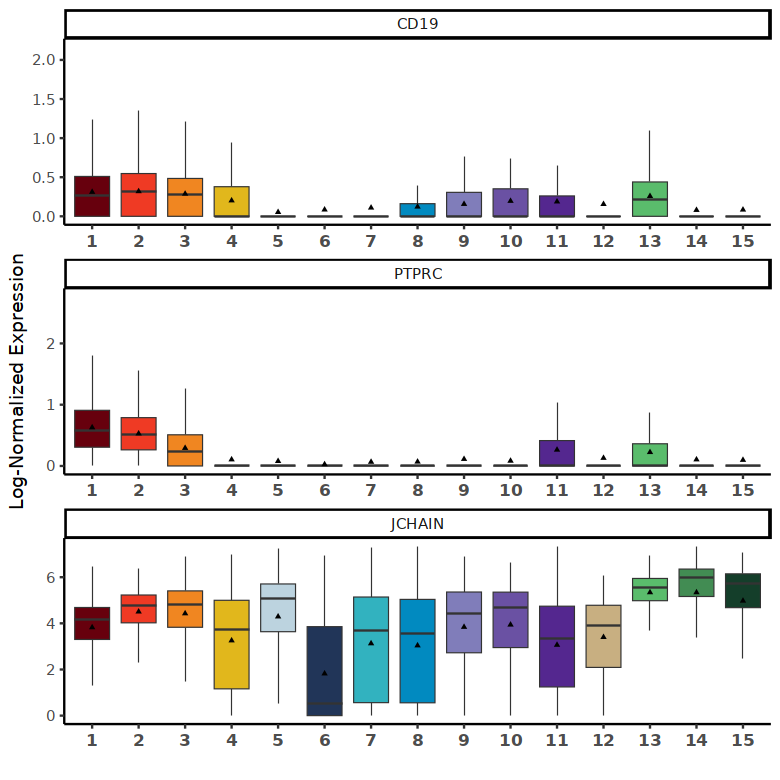

In [39]:
options(repr.plot.width=6.5, repr.plot.height=6.5)
temp = as.matrix(pc[["RNA"]]@data[c("CD19","PTPRC","JCHAIN"),])
temp = as.data.frame(t(temp))
temp$cluster_id = pc$cluster_id
temp = melt(temp,id = "cluster_id")
temp$cluster_id = factor(temp$cluster_id,levels(factor(temp$cluster_id))[c(1:15)])

ggplot(temp,aes(x = factor(cluster_id),y = value,fill = cluster_id)) + 
  geom_boxplot(lwd=0.25,outlier.shape = NA)+
  stat_summary(fun = mean, geom = "point", fill = "white",shape = 17,size = 1)+
  scale_fill_manual(values = cell_cluster.color) +
  ylab("Log-Normalized Expression") +
  #scale_y_continuous(labels = scales::number_format(accuracy = 0.01)) +
  xlab("") +
  theme_classic()+
  theme(axis.text.x = element_text(angle = 0,vjust = 0.5,hjust = 0.5,size =10,face = "bold"),legend.position = "none") +
  facet_wrap(.~variable,scales = "free",ncol=1)